In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

%load_ext lab_black

## ESRI data

The most recent 2020 census tracts are used to aggregate the data. More info about each netCDF is below:
 
- Daily Minimum temperature from 2006-2021  
- Daily Maximum temperature from 2006-2021
- Daily Relative Humidity from 2006-2021  
- Daily Smoke from 2006-2021 
- and Daily PM 2.5 data from 2006-2020

In [2]:
tmax = xr.open_dataset("data/esri/MaxTemp_2006_2021_Cali.nc")

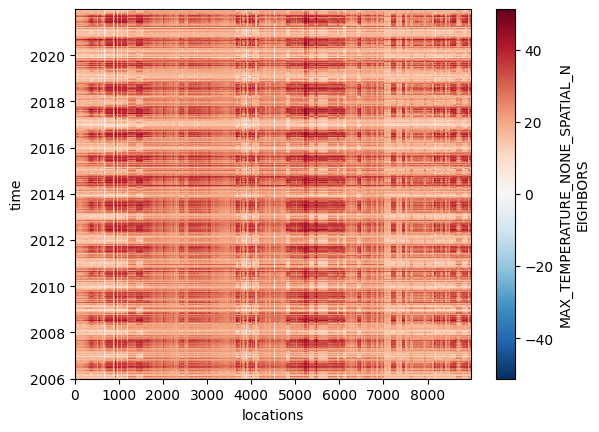

In [29]:
tmax["MAX_TEMPERATURE_NONE_SPATIAL_NEIGHBORS"].plot()

In [3]:
tmin = xr.open_dataset("data/esri/MinTemp_2006_2021_Cali.nc")

In [4]:
rhum = xr.open_dataset("data/esri/RelHum_2006_2021_Cali.nc")

## Join tmax, tmin and rhum

In [5]:
df = xr.merge([tmax, tmin[["MIN_TEMPERATURE_NONE_SPATIAL_NEIGHBORS"]]])

In [6]:
df = xr.merge([df, rhum[["RELATIVE_HUMIDITY_NONE_SPATIAL_NEIGHBORS"]]])

In [7]:
del tmin
del tmax
del rhum

In [8]:
df = df[
    [
        "FIPS",
        "MAX_TEMPERATURE_NONE_SPATIAL_NEIGHBORS",
        "MIN_TEMPERATURE_NONE_SPATIAL_NEIGHBORS",
        "RELATIVE_HUMIDITY_NONE_SPATIAL_NEIGHBORS",
    ]
].to_dataframe()

In [9]:
df = df.rename(
    columns={
        "MAX_TEMPERATURE_NONE_SPATIAL_NEIGHBORS": "tmax",
        "MIN_TEMPERATURE_NONE_SPATIAL_NEIGHBORS": "tmin",
        "RELATIVE_HUMIDITY_NONE_SPATIAL_NEIGHBORS": "rhum",
    }
)

In [14]:
df.head()

FIPS       tmax      tmin       rhum        lat  \
time       locations                                                      
2005-12-31 0          1765.0  13.350000  7.850000  88.400002  37.867656   
           1          1766.0  14.950006  8.249994  91.400002  37.848138   
           2          1767.0  14.950006  8.249994  91.400002  37.840584   
           3          1768.0  14.950006  8.249994  91.400002  37.848284   
           4          1769.0  14.950006  8.249994  91.400002  37.848545   

                             lon  
time       locations              
2005-12-31 0         -122.231882  
           1         -122.249591  
           2         -122.254478  
           3         -122.257445  
           4         -122.264736

In [27]:
df = df.loc[(slice(pd.Timestamp("2006-01-01"), None), slice(None)), :]

In [28]:
df = df.loc[(slice(None, pd.Timestamp("2020-12-31")), slice(None)), :]

In [29]:
df.to_parquet("outputs/temp_merge_1.parquet")

## Add wildfire day

In [2]:
df = pd.read_parquet("outputs/temp_merge_1.parquet")

In [16]:
len(df)

49261689

In [17]:
df = df.reset_index()

In [19]:
df = df.groupby(by=["time", "lat", "lon"]).first()

In [20]:
wf = xr.open_dataset("data/esri/WildfirePresence_2006_2021_CA_daily.nc")

In [35]:
# "FIPS" start at 0, 1, 2, 3,...

In [21]:
wf = wf["FIREDAY_NONE_ZEROS"].to_dataframe()

In [22]:
wf = wf.rename(columns={"FIREDAY_NONE_ZEROS": "wfday"})

In [24]:
len(wf)

53138832

In [26]:
wf = wf.groupby(by=["time", "lat", "lon"]).first()

In [27]:
tqdm.pandas()

In [30]:
df = df.join(wf, rsuffix="_wf").progress_apply(lambda x: x)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.03it/s]


In [31]:
df.to_parquet("outputs/temp_merge_2.parquet")

In [38]:
len(df)

49261689

In [39]:
df.isna().sum()

locations    0
FIPS         0
tmax         0
tmin         0
rhum         0
wfday        0
dtype: int64

## Add PM 2.5

In [32]:
pm25 = xr.open_dataset("data/esri/PM25_Nature_2006_2020_Cali.nc")

In [33]:
df_pm25 = pm25[["MEAN_NONE_SPATIAL_NEIGHBORS"]].to_dataframe()

In [34]:
df_pm25 = df_pm25.rename(columns={"MEAN_NONE_SPATIAL_NEIGHBORS": "pm25"})

In [36]:
df_pm25 = df_pm25.reset_index()

In [41]:
df_pm25 = df_pm25.groupby(by=["time", "lat", "lon"]).first()

In [42]:
df_pm25.head()

locations      pm25
time       lat       lon                             
2005-12-31 32.546764 -117.052858       6282  9.412000
           32.548940 -117.091351       6292  8.834737
           32.555538 -117.047470       6286  9.380000
           32.560157 -116.953002       6287  7.042963
           32.560777 -117.058503       6285  9.832333

In [44]:
df.head()

locations    FIPS       tmax       tmin  \
time       lat       lon                                                    
2006-01-01 32.546764 -117.052858       6372  8181.0  16.850000  11.850000   
           32.548940 -117.091351       6382  8191.0  16.149988  12.350000   
           32.555538 -117.047470       6376  8185.0  16.850000  11.850000   
           32.560157 -116.953002       6377  8186.0  17.050005  10.774996   
           32.560777 -117.058503       6375  8184.0  16.850000  11.850000   

                                        rhum  wfday  
time       lat       lon                             
2006-01-01 32.546764 -117.052858   99.300003    0.0  
           32.548940 -117.091351   95.900002    0.0  
           32.555538 -117.047470   99.300003    0.0  
           32.560157 -116.953002  100.000000    0.0  
           32.560777 -117.058503   99.300003    0.0

In [45]:
df = df.join(df_pm25, rsuffix="_pm25").progress_apply(lambda x: x)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.91it/s]


In [46]:
df.to_parquet("outputs/temp_merge_3.parquet")

In [47]:
df.isna().sum()

locations               0
FIPS                    0
tmax                    0
tmin                    0
rhum                    0
wfday                   0
locations_pm25    1341414
pm25              1341414
dtype: int64

In [51]:
df.head()

locations    FIPS       tmax       tmin  \
time       lat       lon                                                    
2006-01-01 32.546764 -117.052858       6372  8181.0  16.850000  11.850000   
           32.548940 -117.091351       6382  8191.0  16.149988  12.350000   
           32.555538 -117.047470       6376  8185.0  16.850000  11.850000   
           32.560157 -116.953002       6377  8186.0  17.050005  10.774996   
           32.560777 -117.058503       6375  8184.0  16.850000  11.850000   

                                        rhum  wfday  locations_pm25      pm25  
time       lat       lon                                                       
2006-01-01 32.546764 -117.052858   99.300003    0.0          6282.0  3.784000  
           32.548940 -117.091351   95.900002    0.0          6292.0  3.592632  
           32.555538 -117.047470   99.300003    0.0          6286.0  3.780000  
           32.560157 -116.953002  100.000000    0.0          6287.0  3.115926  
           32.560777 -117.058503   99.300003    0.0          6285.0  3.938000

In [60]:
len(df.FIPS.unique())

8991

In [68]:
df = df.reset_index()

## Add crosswalk

In [25]:
df = pd.read_parquet("outputs/temp_merge_3.parquet")

In [26]:
df.head()

locations    FIPS       tmax       tmin  \
time       lat       lon                                                    
2006-01-01 32.546764 -117.052858       6372  8181.0  16.850000  11.850000   
           32.548940 -117.091351       6382  8191.0  16.149988  12.350000   
           32.555538 -117.047470       6376  8185.0  16.850000  11.850000   
           32.560157 -116.953002       6377  8186.0  17.050005  10.774996   
           32.560777 -117.058503       6375  8184.0  16.850000  11.850000   

                                        rhum  wfday  locations_pm25      pm25  
time       lat       lon                                                       
2006-01-01 32.546764 -117.052858   99.300003    0.0          6282.0  3.784000  
           32.548940 -117.091351   95.900002    0.0          6292.0  3.592632  
           32.555538 -117.047470   99.300003    0.0          6286.0  3.780000  
           32.560157 -116.953002  100.000000    0.0          6287.0  3.115926  
           32.560777 -117.058503   99.300003    0.0          6285.0  3.938000

In [27]:
df = df.reset_index()

In [28]:
import geopandas as gpd

In [29]:
gdf = gpd.read_file("data/esri/FIPSMapping.gdb")

In [30]:
df.FIPS = df.FIPS.astype(int)

In [31]:
gdf = gdf.drop(columns=["Shape_Length", "Shape_Area"])

In [32]:
df = df.merge(gdf, on="FIPS")

In [33]:
len(df)

47519367

In [34]:
df.isna().sum()

time                    0
lat                     0
lon                     0
locations               0
FIPS                    0
tmax                    0
tmin                    0
rhum                    0
wfday                   0
locations_pm25    1330229
pm25              1330229
FIPS_1                  0
geometry                0
dtype: int64

In [35]:
type(df)

pandas.core.frame.DataFrame

In [36]:
df = df.drop(columns="geometry")

In [37]:
df.to_parquet("outputs/temp_merge_4.parquet")

## Join smoke PM2.5

In [19]:
# smoke_df = pd.read_parquet("outputs/smoke_pm25_predicted_with_fips.parquet")

In [38]:
smoke_df = pd.read_csv(
    "data/smoke_pm/smoke_pm_all_time_2020_map.csv", parse_dates=["date"]
)

In [39]:
smoke_df.head()

,GEOID,smoke_pm,date
0,6001400100,0.0,2006-01-01
1,6001400200,0.0,2006-01-01
2,6001400300,0.0,2006-01-01
3,6001400400,0.0,2006-01-01
4,6001400500,0.0,2006-01-01


In [42]:
df.head()

,time,lat,lon,locations,FIPS,tmax,tmin,rhum,wfday,locations_pm25,pm25,FIPS_1
0,2006-01-01,32.546764,-117.052858,6372,8181,16.850000,11.850000,99.300003,0.0,6282.0,3.784,6071010032
1,2006-01-02,32.546764,-117.052858,6372,8181,18.749994,8.850000,100.000000,0.0,6282.0,6.400,6071010032
2,2006-01-03,32.546764,-117.052858,6372,8181,22.950006,7.950006,88.900002,0.0,6282.0,11.912,6071010032
3,2006-01-04,32.546764,-117.052858,6372,8181,28.749994,12.850000,55.500000,0.0,6282.0,6.392,6071010032
4,2006-01-05,32.546764,-117.052858,6372,8181,28.850000,12.649988,22.500000,0.0,6282.0,10.996,6071010032


In [41]:
df["FIPS_1"] = df["FIPS_1"].astype(int)

In [43]:
merged = df.merge(smoke_df, left_on=["FIPS_1", "time"], right_on=["GEOID", "date"])

In [44]:
merged.head()

,time,lat,lon,locations,FIPS,tmax,tmin,rhum,wfday,locations_pm25,pm25,FIPS_1,GEOID,smoke_pm,date
0,2006-01-01,32.546764,-117.052858,6372,8181,16.850000,11.850000,99.300003,0.0,6282.0,3.784,6071010032,6071010032,0.0,2006-01-01
1,2006-01-02,32.546764,-117.052858,6372,8181,18.749994,8.850000,100.000000,0.0,6282.0,6.400,6071010032,6071010032,0.0,2006-01-02
2,2006-01-03,32.546764,-117.052858,6372,8181,22.950006,7.950006,88.900002,0.0,6282.0,11.912,6071010032,6071010032,0.0,2006-01-03
3,2006-01-04,32.546764,-117.052858,6372,8181,28.749994,12.850000,55.500000,0.0,6282.0,6.392,6071010032,6071010032,0.0,2006-01-04
4,2006-01-05,32.546764,-117.052858,6372,8181,28.850000,12.649988,22.500000,0.0,6282.0,10.996,6071010032,6071010032,0.0,2006-01-05


In [45]:
len(merged)

46912257

In [46]:
merged = merged.drop(
    columns=["lat", "lon", "locations", "FIPS", "locations_pm25", "date"]
)

In [47]:
merged.to_parquet("outputs/final_merge_5.parquet")

In [48]:
merged.isna().sum()

time              0
tmax              0
tmin              0
rhum              0
wfday             0
pm25        1315179
FIPS_1            0
GEOID             0
smoke_pm          0
dtype: int64

In [97]:
gdf = gpd.read_file("data/esri/FIPSMapping.gdb")

<Axes: >

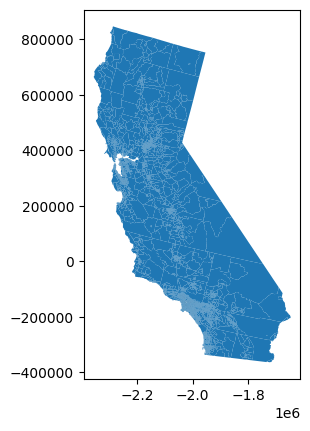

In [76]:
gdf.plot()

In [95]:
temp = merged.groupby("FIPS").sum()

In [96]:
temp = temp.reset_index()

In [86]:
temp.dtypes

FIPS         float64
locations      int64
tmax         float64
tmin         float64
rhum         float64
wfday        float64
dtype: object

In [89]:
gdf.dtypes

FIPS               int64
FIPS_1            object
Shape_Length     float64
Shape_Area       float64
geometry        geometry
dtype: object

In [98]:
temp.FIPS = temp.FIPS.astype(int)

In [99]:
gdf = gdf.merge(temp, left_on="FIPS", right_on="FIPS")

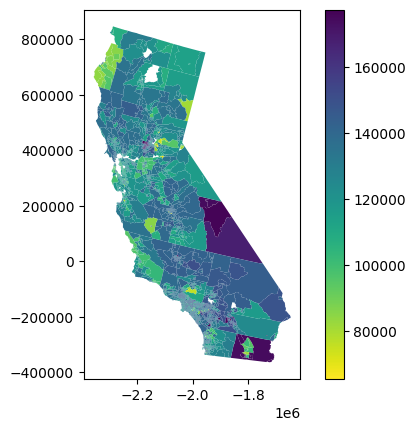

In [100]:
fig, ax = plt.subplots(1, 1)
gdf.plot(column="tmax", ax=ax, legend=True, linewidth=0, cmap="viridis_r")

plt.show()

In [66]:
import matplotlib.pyplot as plt

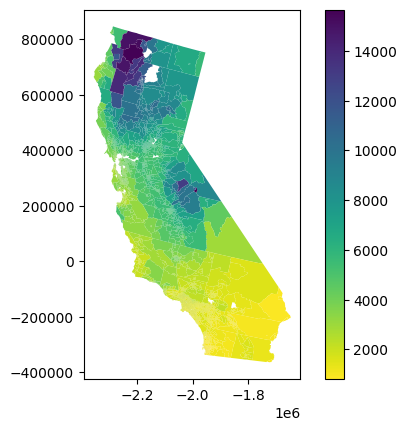

In [68]:
fig, ax = plt.subplots(1, 1)
gdf.plot(column="smoke_pm", ax=ax, legend=True, linewidth=0, cmap="viridis_r")

plt.show()